<center>
<h1>Факультет "Прикладная математика" МАИ</h1>
<h2>Курс "Основы Python для анализа данных"</h2>
<h2>Артамонов Игорь Михайлович</h2>
</center>

<center><h2>Занятие № 11. Обучение без учителя. PCA. Кластеризация.</h2></center>

## Общение / вопросы по курсу

Платформа для групповой работы Atlassian Confluence факультета "Прикладная математика"

https://mai.moscow/display/PYTML

* <b>Занятие № 11. Обучение без учителя. PCA. Кластеризация.</b>

## virtualenv + Jupyter notebook

```
<Ctrl> + <Alt> + T - новое окно терминала
```

```
$ conda -V

$ conda update conda

$ conda search "^python$"

$ conda create -n yourenvname python=x.x anaconda

$ source activate yourenvname

$ jupyter notebook

$ conda install -n yourenvname [package]
```

##  Обучение без учителя. Кластеризация.</h2></center>

#### Задачи машинного обучения
* регрессия
* классификация
* кластеризация

#### Обычный порядок действий
* получить "сырые" данные
* понять, что они из себя представляют (см. EDA)
* привести их в вид, пригодный для обучения модели
* разбить тренировочную выборку на две: обучающую и проверочную (валидационную)
* сравнить несколько алгоритмов машинного обучения, их настроек, чтобы получить наилучший результат для P на валидационной выборке
* (_возможно_) повторить предыдущие три этапа несколько раз
* обучить "лучшую" модель на всей тренировочной выборке
* использовать модель для получения каких-то результатов
* (_возможно_) провести дообучение модели с полученными свежими данными

Алгоритмы кластеризации разбивают заанное множество объектов на группы (кластеры) таким образом, 
чтобы в одном кластере размещались __близкие__ по своим характеристикам объекты, а в разных - __далекие__ объекты.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from numpy.random import randn
import seaborn as sns
from scipy import stats

import matplotlib as mpl
from matplotlib.patches import Ellipse
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import os
import os.path

## Обучение без учителя

__Метод главных компонент__ – понижение размерности входных<br>
__Кластеризация__ – разбиение множества объектов на группы на основании анализа признаков этих объектов так, чтобы внутри групп объекты были, в некотором смысле, более "близкими" между собой, а вне одной группы – менее "близкими"

### __<font color="green">ВОПРОС?</font>__ 
Для чего может потребоваться понижение размерности?

### __<font color="blue">ВАЖНО!</font>__ 
В реальных задачах кластеризация / понижение размерности и другие алгоритмы обучения без учителя
почти всегда используются как один из этапов анализа / оптимизации / сокращения объема обрабатываемы даных,
а не как самостоятельное средство анализа.

### Цели кластеризации:
* Упростить дальнейшую обработку данных, разбив множество объектов на группы схожих объектов, чтобы работать с каждой группой по отдельности (_задачи классификации, регрессии, прогнозирования_)
* сократить объем хранимых данных, оставив по одному представителью от каждого кластера (_задачи сжатия данных_)
* выделить натипичные объекты, которые не подходят ни к одному из кластеров (_задачи одноклассовой классификации_)
* Построить иерархию множества объектов (_задача таксономии_)

## <font color=green>ВОПРОС</font>
* Можно ли использовать дерево для регрессии?
* Можно ли использовать дерево для кластеризации?

### Метод главных компонент (_PCA - Principal Component Analysis_)

<img src="images11/fig-pca-principal-component-analysis-m.png">

```
https://habr.com/post/304214/ - отличное объяснение
https://habr.com/company/ods/blog/325654/ - хорошо разобранный пример для датасета по цветкам ириса
```

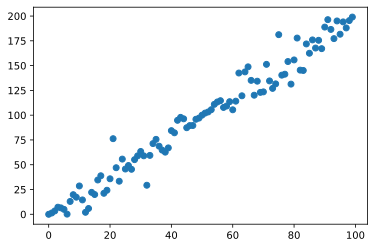

In [9]:
N = 100
x = np.arange(0,N)
y = 2 * x + np.random.randn(N) * 10 * np.sin((100-x)*np.pi/50 )  * np.abs(N-50) * 0.03
X = np.vstack((x,y))
plt.scatter(x, y)

Отцентрируем выборку

Среднее вектора:  (49.5, 96.5435755543229)


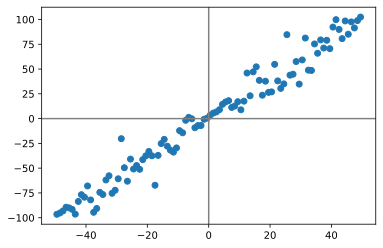

In [10]:
Xcentered = (X[0] - x.mean(), X[1] - y.mean())
m = (x.mean(), y.mean())
plt.scatter(Xcentered [0], Xcentered [1])
plt.axvline(0, color="grey")
plt.axhline(0, color="grey")
print ("Среднее вектора: ", m)

### <font color="green">ВОПРОС</font>
* Для чего мы центрируем выборку?<br>
* Для чего нам в будущем может потребоваться среднее?

### Ковариационная матрица

(-50, 50)

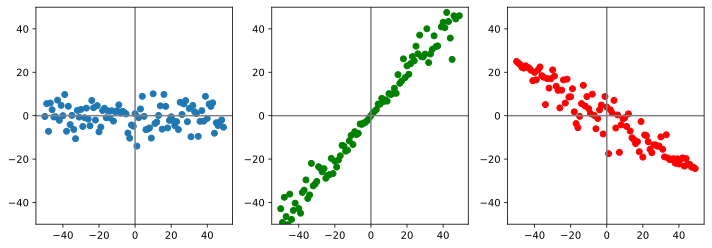

In [11]:
x_range = np.arange(-50,50)
fig = plt.figure(figsize=(12, 4))

def f1(x): return x * 0 + np.random.randn(x.shape[0])* 5
def f2(x): return x + np.random.randn(x.shape[0]) * 6 * np.sin((x.shape[0]-x)*np.pi/x.shape[0])
def f3(x): return -0.5*x - np.random.randn(x.shape[0])* 7 * np.sin((x.shape[0]-x+x.shape[0]/2)*np.pi/x.shape[0])
#
y1 = f1(x_range)
fig.add_subplot(1,3,1)
plt.scatter(x_range, y1)
plt.axvline(0, color="grey")
plt.axhline(0, color="grey")
plt.ylim(-50, 50)
fig.add_subplot(1, 3,2)
#
y2 = f2(x_range)
plt.scatter(x_range, y2, color="green")
plt.axvline(0, color="grey")
plt.axhline(0, color="grey")
plt.ylim(-50, 50)
fig.add_subplot(1, 3,3)
#
y3 = f3(x_range)
plt.scatter(x_range, y3, color="red")
plt.axvline(0, color="grey")
plt.axhline(0, color="grey")
plt.ylim(-50, 50)



Для описания формы случайного вектора нужна ковариационная матрица:<br><br>
$$
Cov(X_i,X_j) = E[(X_i-E(X_i)) \cdot  (X_j-E(X_j))] = E(X_i X_j) - E(X_i) \cdot E(X_j)
$$<br>
Поскольку в нашем случае $E(X_i) = E(X_j) = 0$, то<br><br>
$$
Cov(X_i,X_j) = E(X_i X_j) 
$$<br>
Заметим, что если $X_i = X_j$, то <br><br>
$$
Cov(X_i,X_j) = Var(X_i) 
$$<br>

### <font color="green">ВОПРОС</font>
* Что будет на диагонали матрицы?<br>
* Что будет, если функция сильно нелинейна?<br>

In [12]:
covmat = np.cov(Xcentered)
print (covmat, "\n")
print ("Дисперсия X: ", np.cov(Xcentered)[0,0])
print ("Дисперсия Y: ", np.cov(Xcentered)[1,1])
print ("Ковариация X и Y: ", np.cov(Xcentered)[0,1])

[[ 841.66666667 1688.65478254]
 [1688.65478254 3503.94777719]] 

Дисперсия X:  841.6666666666667
Дисперсия Y:  3503.94777719213
Ковариация X и Y:  1688.6547825424843


### 3. Собственные вектора и значения

Мы получили матрицу, описывающую форму случайной величины. Теперь требуется найти такой вектор, 
при котором максимизировался бы размер (дисперсия) проекции нашей выборки на него

Проекция единичного вектора $v$ на наш случайный вектор $X$ равна $v^\intercal X$. В более общей векторной форме (для центрированных величин) дисперсия выражается так:<br><br>
$$
Var(X) = \sum = E(X \cdot X^\intercal)
$$
<br>Соответственн, дисперсия проекции:<br><br>
$$
Var(X^*) = \sum {^*} = E(X^* \cdot X^{*\intercal}) = \\
    E(( \overrightarrow{v}^\intercal X) \cdot ( \overrightarrow{v}^\intercal X)^\intercal) = \\
    E( \overrightarrow{v}^\intercal X \cdot \overrightarrow{v} X^\intercal) = \\
    \overrightarrow{v}^\intercal \sum \overrightarrow{v}
$$

Легко замеить, что дисперсия максимизируется при максимальном значении $v^\intercal \sum v$ Существует отношение Рэлея (https://ru.wikipedia.org/wiki/Отношение_Рэлея), которое имеет специальный случай для ковариационных матриц :<br><br>
$$
R(M, \overrightarrow{x}^\intercal) = \frac { \overrightarrow{x}^\intercal M \overrightarrow{x}}  
                                           { \overrightarrow{x}^\intercal \overrightarrow{x}}  =
                                           \lambda \frac { \overrightarrow{x}^\intercal \overrightarrow{x}}  
                                           { \overrightarrow{x}^\intercal \overrightarrow{x}} = 
                                           \lambda
$$
и
$$M \overrightarrow{x} = \lambda \overrightarrow{x}$$<br>
где $\overrightarrow{x}$ является собетсенным вектором, а $\lambda$ - собственным значением

Таким образом, направление максимальной дисперсии у проекции всегда совпадает с собственным вектором, 
имеющим максимальное собственное значение, равное величине этой дисперсии, причем это верно также для проекций на большее число измерений. Ковариационная матрица проекции на $m$-мерное пространство будет максимальна в направлении $m$ собственных векторов, имеющих максимальные собственные значения. 

Вычисляем матрицу ковариации

In [ ]:
covX = np.cov(X)
covX

Вычисляем собственные значения и собственные вектора

In [ ]:
eig_val, eig_vect = np.linalg.eig(covX)
print(eig_val)
print(eig_vect)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(6,6))
y3 = f3(x_range)
plt.scatter(x_range, y3, color="red")
plt.axvline(0, color="grey")
plt.axhline(0, color="grey")
plt.ylim(-50, 50)

x1, y1, x2, y2 = eig_vect.reshape(-1) * 50
angle = np.arctan( (y2-y1) / (x1-x2)  ) * 180

w, h = np.sqrt(eig_val)*1.5
el = Ellipse((0, 0), width=w, height=h,
                     angle=angle, linewidth=1, fill=False)  # in data coordinates!
ax.add_artist(el)
plt.show()

### 4. Снижение размерности (проекция)

Наибольший вектор имеет направление, схожее с линией регрессии. Cпроецировав его на него нашу выборку,
мы потеряем информацию, сравнимую с суммой остаточных членов регрессии (только расстояние теперь
евклидово, а не дельта по Y). В нашем случае зависимость между признаками очень сильная, так что
потеря информации будет минимальна. «Цена» проекции — дисперсия по меньшему собственному вектору — как
видно из предыдущего графика, очень невелика.

__Замечание:__ диагональные элементы ковариационной матрицы показывают дисперсии по изначальному базису, 
    а ее собственные значения – по новому (по главным компонентам).

__Замечание:__ На практике, в большинстве случаев, если суммарная потеря информации составляет не более 10-20%,
    то можно спокойно снижать размерность.

Для проведения проекции надо выполнить операцию $v^\intercal X$ (если у нас один вектор). Если же у нас гиперплоскость, то берем матрицу базисных векторов $V^\intercal X$

In [ ]:
v = -eig_vect[:,1]
Xnew = np.dot(v,Xcentered)
print (Xnew)

## 5. Восстановление данных

У нас есть вся необходимая информация, а именно координаты базисных векторов в исходном базисе 
(векторы, на которые мы проецировали) и вектор средних (для отмены центровки). Возьмем, к примеру,
наибольшее значение: 94.577 и раскодируем его. Для этого умножим его справа на транспонированный вектор и прибавим вектор средних, или в общем виде для всей выборки: $X^\intercal v^\intercal +m$^


In [ ]:
n = 10     #номер элемента случайной величины
Xrestored = np.dot(Xnew[n],v) + m
print ('Восстановленный: ', Xrestored)
print ('Оригинальный: ', X[:,n])

## 6. Сравнение с SKlearn

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
XPCAreduced = pca.fit_transform(X.T)

In [ ]:
print ('Our reduced X: \n', Xnew)
print ('Sklearn reduced X: \n', XPCAreduced)

## <font color="red">ЗАДАНИЕ</font>

In [ ]:
%ls pictures

* Загрузите изображения из каталога pictures. 
* Оставьте последовательно 5, 15 и 30 главных компонент по каждому каналу цветности.
* Выведите соответствующие изображение

In [ ]:
# Ваш код



## Кластеризация

Предполагается, что внутри наших данных имеется какие-то группы. Мы можем захотеть:
* выделить эти группы
* понять, что их отличает друг от друга
* получить возможность сократить врем

<img src="images11/cluster_comparison.png">
http://commons.apache.org/proper/commons-math/userguide/ml.html

Классификация алгоритмов (https://habr.com/post/101338/)

__Иерархические и плоские__<br><br>

_Иерархические_ алгоритмы (алгоритмы _таксономии_) строят не одно разбиение выборки на
непересекающиеся кластеры, а систему вложенных разбиений. Т.о. на выходе мы получаем дерево кластеров,
корнем которого является вся выборка, а листьями — наиболее мелкие кластера.<br><br>
_Плоские_ алгоритмы строят одно разбиение объектов на кластеры.
<br><br>
__Четкие и нечеткие__<br><br>
_Четкие_ (или _непересекающиеся_) алгоритмы каждому объекту выборки ставят в соответствие номер кластера,
т.е. каждый объект принадлежит только одному кластеру. <br><br>
_Нечеткие_ (или _пересекающиеся_) алгоритмы каждому
объекту ставят в соответствие набор вещественных значений, показывающих степень отношения объекта к
кластерам. Т.е. каждый объект относится к каждому кластеру с некоторой вероятностью.<br>

### Метрики расстояний

Евклидово расстояние
$$ \rho (x, x') = \sqrt{ \sum_i^m (x_i - x'_i)^2} $$
<br>Квадрат евклидова расстояния
$$ \rho (x, x') = \sum_i^m (x_i - x'_i)^2 $$
<br>Манхэттенское расстояние
$$ \rho (x, x') = \sum_i^m \mid (x_i - x'_i) \mid $$
<br>Расстояние Чебышева
$$ \rho (x, x') = max ( \mid x_i - x'_i \mid ) $$
<br>Степенное расстояние
$$ \rho (x, x') = \sqrt[r]{ \sum_i^m (x_i - x'_i)^p} $$

Алгоритм __К-средних (K-means)__ - популярный и простой алгоритм кластеризации, состоящий из следующих шагов:

* Выбрать количество кластеров $K$, которые мы считаем целесообразным;
* Сгенерировать случайным образом в пространстве поиска $k$ центроидов (точек будущей группировки).
* Вычислить для каждой точки набора данных расстояние до центроидов и определить, к какому центроиду она ближе.
* Переместить каждый центроид в центр выборки, отнесенной к этому центроиду.
* Повторять два последних два шага либо до момента "схождения" (обычно это определяется по тому, что их смещение по
отношению к предыдущему положению не превышает заранее заданного небольшого значения), либо заданное количество шагов.

Пример из https://habr.com/company/ods/blog/325654/ :

In [ ]:
# Начнём с того, что насыпем на плоскость три кластера точек
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [ ]:
# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
from scipy.spatial.distance import cdist

# Прибьём рандомность и насыпем три случайные центроиды для начала
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Считаем расстояния от наблюдений до центроид
    distances = cdist(X, centroids)
    # Смотрим, до какой центроиде каждой точке ближе всего
    labels = distances.argmin(axis=1)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

In [ ]:
# А теперь нарисуем всю эту красоту
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)

    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

### Выбор числа кластеров для kMeans

В основе (обычно) - здравый смысл. Однако для K-means часто используют такую метрику:
$$
J(C)= \sum_{k=1}^K \sum_{i \in C_k} \mid \mid x_i - \mu _k \mid \mid ^2 \rightarrow min
$$
где $C$ - множество кластеров мощности $K$, $\mu _k$ - центроид кластера $C_k$
<br><br>Часто выбирают число кластеров, начиная с которого функционал $J(C)$ падает "не так быстро"<br><br>
$$
D(K) = \frac {J(C_k)-J(C_{k+1})} {J(C_{k-1})-J(C_{k})}
$$


### Агломеративная кластеризация

* Начальное разбиение - каждая точка является центроидом кластера, состоящего только из нее
* Сортируем попарные расстояния между центрами кластеров по возрастанию
* Берём пару ближайших кластеров, объединяем их в один и пересчитываем центр кластера
* повторяем п. 2 и 3 до тех пор, пока все данные не склеятся в один кластер

Существуют различные методы объединения точек:
* Single linkage — минимум попарных расстояний между точками из двух кластеров<br><br>
$$
d(C_i, C_j) = min_{x \in C_i, x_j \in C_j} \mid \mid x_i - x_j \mid \mid
$$<br>
* Complete linkage — максимум попарных расстояний между точками из двух кластеров<br><br>
$$
d(C_i, C_j) = max_{x \in C_i, x_j \in C_j} \mid \mid x_i - x_j \mid \mid
$$<br>
* Average linkage — среднее попарных расстояний между точками из двух кластеров<br><br>
$$
d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x \in C_i} \sum_{x_j \in C_j} \mid \mid x_i - x_j \mid \mid
$$<br>
* Centroid linkage — расстояние между центроидами двух кластеров<br><br>
$$
d(C_i, C_j) = \mid \mid \mu _i - \mu _j \mid \mid
$$<br>

Пример из https://habr.com/company/ods/blog/325654/:

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

distance_mat = pdist(X) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'single') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

## Affinity propagation ("Распространение близости")

https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html#sphx-glr-auto-examples-cluster-plot-affinity-propagation-py

* Получает на вход матрицу схожести между элементами датасета $S = N x N$
* Возвращает набор меток, присвоенных этим элементам

In [ ]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))



In [ ]:
# #############################################################################
# Plot result
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## <font color="red">ЗАДАНИЕ</font>

In [14]:
# Загружаем MNIST

import numpy as np
from sklearn.datasets import load_digits

mnist = load_digits()
X = mnist.data / 255.0
y = mnist.target

print (X.shape, y.shape)

(1797, 64) (1797,)


Из проекции на плоскость (2 основных компоненты) видно, что имеются явно выраженные кластеры

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection')

* Обучите ансамбль из 20 случайных деревьев

In [ ]:
# Ваш код


* Напишите функцию, сокращающую размерность входных чисел

In [ ]:
# Ваш код


* Постепенно увеличивая размерность от 1, добейтесь того, чтобы полученная Вами точность отличалась от
точности на полных изображениях не более, чем на:
    - 10%
    - 5%

In [ ]:
# Ваш код


* Постройте график зависимости точности от количества главных компонент

In [ ]:
# Ваш код


## Экзаменационные вопросы:

* обучение без учителя
* метод главных компонент
* методы кластеризации